In [21]:
!pip install torch
!pip install torchaudio
!pip install torch diffusers
!pip install torchvision
!pip install transformers
!pip install accelerate
!pip install translate
!pip install rutube-downloader m3u8 alive_progress
!pip install opencv-python
!pip install beautifulsoup4
!pip install detectron2

ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [22]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone "https://github.com/facebookresearch/detectron2"
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [23]:
import cv2
import torch
from typing import Tuple
import numpy as np
import os
import os.path
import pandas as pd
from diffusers import StableDiffusionPipeline
from translate import Translator
import requests
from rutube import Rutube
from bs4 import BeautifulSoup
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import os, json, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [24]:
nums = ['person\n', 'bicycle\n', 'car\n', 'motorbike\n', 'aeroplane\n', 'bus\n', 'train\n', 'truck\n', 'boat\n', 'traffic light\n', 'fire hydrant\n', 'stop sign\n', 'parking meter\n', 'bench\n', 'bird\n', 'cat\n', 'dog\n', 'horse\n', 'sheep\n', 'cow\n', 'elephant\n', 'bear\n', 'zebra\n', 'giraffe\n', 'backpack\n', 'umbrella\n', 'handbag\n', 'tie\n', 'suitcase\n', 'frisbee\n', 'skis\n', 'snowboard\n', 'sports ball\n', 'kite\n', 'baseball bat\n', 'baseball glove\n', 'skateboard\n', 'surfboard\n', 'tennis racket\n', 'bottle\n', 'wine glass\n', 'cup\n', 'fork\n', 'knife\n', 'spoon\n', 'bowl\n', 'banana\n', 'apple\n', 'sandwich\n', 'orange\n', 'broccoli\n', 'carrot\n', 'hot dog\n', 'pizza\n', 'donut\n', 'cake\n', 'chair\n', 'sofa\n', 'pottedplant\n', 'bed\n', 'diningtable\n', 'toilet\n', 'tvmonitor\n', 'laptop\n', 'mouse\n', 'remote\n', 'keyboard\n', 'cell phone\n', 'microwave\n', 'oven\n', 'toaster\n', 'sink\n', 'refrigerator\n', 'book\n', 'clock\n', 'vase\n', 'scissors\n', 'teddy bear\n', 'hair drier\n', 'toothbrush\n']

In [26]:
#model_id = ''
#prompt = ''
#path = ''
#description = ''
#title = ''
file_name = input()
video_link = input()
prompt = input()
req = requests.get(video_link).text
category = req[req.find("category_url") + 12:]
category = category[:category.find("}")]
category = category[category.find("name")+5:]
category = category[category.find("\"")+1:category.rfind("\"")]
name = req[req.find('<title data-react-helmet="true">') + 32:]
name = name[:name.find(" смотреть онлайн видео от ")]
description = req[req.find('"description": ')+16:]
description = description[:description.find("\n")]

0.mp4
https://rutube.ru/video/a019c03cdf1a178ce95f49bb737d0bf8/
На голубом фоне


In [27]:
def split_video():
    #os.mkdir(fr"c:\sochi\Frames\{file_name}")
    global file_name
    video = cv2.VideoCapture(f"/content/drive/MyDrive/{file_name}")
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = total_frames // 60
    count = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            print(f"Кадр {count} сохранён.")
            if not os.path.exists(f"/content/drive/MyDrive/Frames_{file_name}"):
              os.makedirs(f"/content/drive/MyDrive/Frames_{file_name}")
            cv2.imwrite(f"/content/drive/MyDrive/Frames{file_name}/{count}.jpg", frame)
            count += 1
        frame_count += 1
    video.release()
    cv2.destroyAllWindows()

split_video()

In [28]:
translator = Translator(from_lang='ru', to_lang='en')

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [30]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
counts_dict = {}
from google.colab.patches import cv2_imshow
path = f"/content/drive/MyDrive/Frames_{file_name.rstrip('.mp4')}/"
for i in range(61):
    im = cv2.imread(f'{path}{i}.jpg')
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    for i in list(outputs["instances"].pred_classes):
        if f'{nums[i]}' not in counts_dict.keys():
          counts_dict[f'{nums[i]}'] = 0
        counts_dict[f'{nums[i]}'] += 1

[10/14 20:36:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 126MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/14 20:36:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[10/14 20:36:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[10/14 20:36:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[10/14 20:36:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[10/14 20:36:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/

In [34]:
print(counts_dict)
counts_dict = sorted(counts_dict, key=lambda item: item[1])
if len(counts_dict) >= 5:
  counts_dict = counts_dict[:5]
print(counts_dict)

['handbag\n', 'car\n', 'person\n', 'cell phone\n', 'aeroplane\n']
['handbag\n', 'car\n', 'person\n', 'cell phone\n', 'aeroplane\n']


In [35]:
line = category.lower() + " "
new_name = ""
new_description = ""
new_prompt = ""
for i in name.lower():
  if i.isalpha() or i == " ":
    new_name += i
line += " " + new_name
for i in counts_dict:
  line += i[0].rstrip("\n") + " "
for i in description.lower():
  if i.isalpha() or i == " ":
    new_description += i
line += " " + new_description
for i in prompt.lower():
  if i.isalpha() or i == " ":
    new_prompt += i
line += " " + new_prompt
line = translator.translate("line")
line

'line'

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

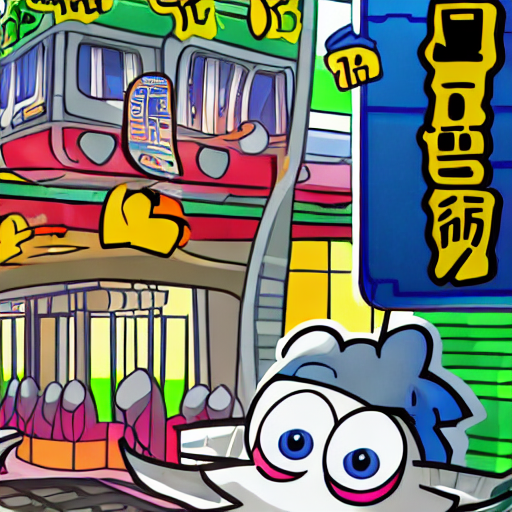

In [36]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16).to("cuda")
image = pipe(line).images[0]
image.save(f"cover.jpg")
image